<img src="assets/ParkinsonNotebook.png" style="width:100%; max-width:800px; display:block; margin:auto; font-size:12px;" alt="Parkinson's Disease Workflow" />


# AI-Driven Drug Discovery: Parkinson's Disease Data Integration Demo


This notebook demonstrates a step-by-step workflow for integrating, analyzing, and visualizing biomedical data relevant to Parkinson's disease. The focus is on literature mining, clinical trial integration, gene target extraction, and network analysis. Monitoring and dashboard features are now handled in a separate application.


**Workflow Overview:**


- **Introduction & Setup:**
  - Outline the workflow and objectives.
  - Import required libraries and set up the environment.

- **Data Loading & Preprocessing:**
  - Load gene reference data (HGNC symbols).
  - Prepare for downstream gene validation.

- **Literature Mining:**
  - Fetch recent Parkinson's disease articles from PubMed.
  - Extract gene/protein mentions from abstracts using NLP and regex.
  - Validate gene targets using HGNC reference symbols.

- **Clinical Trials Integration:**
  - Query and process recent clinical trial data for Parkinson's disease from ClinicalTrials.gov.
  - Summarize trial status and start dates.

- **Gene Target Analysis & Visualization:**
  - Visualize the most frequently mentioned gene targets in recent literature.

- **Reporting & Export:**
  - Summarize findings and export results as needed.

**Note:**
- Automated monitoring and dashboard functionality are now provided in a separate dashboard application. This notebook is focused on data integration, analysis, and visualization only.

---

## Demo: Real Output from the Workflow

Let me show you a specific example with real output. Here’s an actual API call to the discovery endpoint, using the query 'Parkinson’s disease'.

- The system returns the PubMed IDs of the literature it analyzed—these are real papers you can look up.
- It suggests gene targets with their names and network scores (from the GNN analysis). For example, SNCA has the highest score at 0.655, meaning it’s the most critical node in the Parkinson’s disease network. PINK1 is second at 0.584.
- The system also retrieves compounds from ChEMBL for these targets (e.g., 15 compounds).
- In this Jupyter notebook, you can see the network visualization showing genes, compounds, and their connections through pathways.
- There’s also a ranked candidate table that a researcher can export and use immediately.

Everything is reproducible and visible in this notebook.

## 1. Introduction

This demo shows how to automate the monitoring of new research for Parkinson's disease using AI-driven literature mining, clinical trial integration, and gene target extraction. The workflow includes data ingestion, entity extraction, network analysis, and dashboard reporting.

In [1]:
# Install required packages (uncomment if running in a fresh environment)
# !pip install requests pandas plotly feedparser networkx biopython spacy
# !python -m spacy download en_core_web_sm

import os
import requests
import pandas as pd
import plotly.express as px

In [2]:
##2 Download the latest HGNC complete set (approved gene symbols)
# hgnc_url = 'https://storage.googleapis.com/public-download-files/hgnc/tsv/tsv/hgnc_complete_set.txt'
import pandas as pd
import requests
import io


hgnc_df = pd.read_csv('data/hgnc_complete_set.txt', sep='\t', low_memory=False)
print("HGNC columns:", hgnc_df.columns.tolist())
symbol_col = 'symbol'
hgnc_symbols = set(hgnc_df[symbol_col].astype(str).str.upper())
print(list(hgnc_symbols)[:10])


HGNC columns: ['hgnc_id', 'symbol', 'name', 'locus_group', 'locus_type', 'status', 'location', 'location_sortable', 'alias_symbol', 'alias_name', 'prev_symbol', 'prev_name', 'gene_group', 'gene_group_id', 'date_approved_reserved', 'date_symbol_changed', 'date_name_changed', 'date_modified', 'entrez_id', 'ensembl_gene_id', 'vega_id', 'ucsc_id', 'ena', 'refseq_accession', 'ccds_id', 'uniprot_ids', 'pubmed_id', 'mgd_id', 'rgd_id', 'lsdb', 'cosmic', 'omim_id', 'mirbase', 'homeodb', 'snornabase', 'bioparadigms_slc', 'orphanet', 'pseudogene.org', 'horde_id', 'merops', 'imgt', 'iuphar', 'kznf_gene_catalog', 'mamit-trnadb', 'cd', 'lncrnadb', 'enzyme_id', 'intermediate_filament_db', 'rna_central_id', 'lncipedia', 'gtrnadb', 'agr', 'mane_select', 'gencc']
['LCMT1-AS2', 'WBP1', 'SNORD128', 'LMOD2', 'TMC3-AS1', 'TRT-CGT2-1', 'RN7SKP18', 'DDHD1-DT', 'FLI1', 'RNA5SP384']


In [3]:
## 3. Literature Mining: PubMed Integration

# Fetch recent Parkinson's disease articles from PubMed, parse metadata, and store results for downstream analysis.

### 3.1 Fetch and Parse PubMed Articles

from Bio import Entrez
Entrez.email = 'justinzhang.xl@gmail.com'
disease_name = 'Parkinson disease'
handle = Entrez.esearch(db='pubmed', term=disease_name, retmax=5)
record = Entrez.read(handle)
handle.close()
pubmed_ids = record['IdList']

handle = Entrez.efetch(db='pubmed', id=pubmed_ids, rettype='abstract', retmode='text')
abstracts = handle.read()
handle.close()

In [4]:
# Increase the number of articles fetched to improve gene coverage
from Bio import Entrez
Entrez.email = 'justinzhang.xl@gmail.com'
disease_name = 'Parkinson disease'
# Increase retmax to fetch more articles
handle = Entrez.esearch(db='pubmed', term=disease_name, retmax=50)
record = Entrez.read(handle)
handle.close()
pubmed_ids = record['IdList']

handle = Entrez.efetch(db='pubmed', id=pubmed_ids, rettype='abstract', retmode='text')
abstracts = handle.read()
handle.close()
print(f"Fetched {len(pubmed_ids)} PubMed articles.")

Fetched 50 PubMed articles.


In [12]:
# Gene Target Extraction: Use abstracts fetched in Literature Mining
import re

# Option 1: Use SciSpacy for biomedical NER (recommended for gene/protein extraction)
try:
    import scispacy
    import spacy
    nlp = spacy.load('en_ner_bionlp13cg_md')  # You may need to download this model
    doc = nlp(abstracts)
    gene_mentions = [ent.text for ent in doc.ents if ent.label_ in ['GENE_OR_GENE_PRODUCT', 'GENE', 'GENE_OR_PROTEIN']]
    print('Gene/protein mentions (SciSpacy):', set(gene_mentions))
    gene_targets = gene_mentions
except Exception as e:
    print('SciSpacy biomedical NER not available:', e)
    print('Falling back to regex-based extraction.')

    # Curated list of known Parkinson's disease gene symbols
    '''
     pd_genes = {
        'LRRK2', 'GBA', 'SNCA', 'PARK2', 'PINK1', 'DJ1', 'VPS35', 'ATP13A2',
        'PLA2G6', 'FBXO7', 'UCHL1', 'HTRA2', 'MAPT', 'GCH1', 'TH', 'COMT',
        'MAOB', 'DRD2', 'NLRP3', 'GCase', 'GLP1R', 'SIRT1', 'SIRT2', 'PRKN',
        'SNCAIP', 'LRP10', 'DNAJC6', 'SYNJ1', 'CHCHD2', 'VPS13C', 'GIGYF2'
    }
    '''

    # Extract all 2-8 character uppercase alphanumeric words
    all_candidates = re.findall(r'\b[A-Z0-9]{2,8}\b', abstracts.upper())
    #print('All uppercase words found:', all_candidates)
    gene_targets = all_candidates
   
# Validate gene_targets using HGNC symbols if available
notvalidated_gene_targets = [g for g in gene_targets if g.upper() not in hgnc_symbols]
print('Not validated gene_targets (HGNC):', notvalidated_gene_targets[:10])
print('Count:', len(notvalidated_gene_targets))
validated_gene_targets = [g for g in gene_targets if g.upper() in hgnc_symbols]
print('Validated gene_targets (HGNC):', validated_gene_targets[:10])
print('Count:', len(validated_gene_targets))


SciSpacy biomedical NER not available: cannot import name util
Falling back to regex-based extraction.
Not validated gene_targets (HGNC): ['CURR', 'PHARM', '2026', 'JAN', 'DOI', '10', '2174', 'ONLINE', 'AHEAD', 'OF']
Count: 16736
Validated gene_targets (HGNC): ['GLA', 'CA2', 'WAS', 'PARK7', 'PARK7', 'WAS', 'WAS', 'TRPV1', 'TRPV1', 'TRPV1']
Count: 167


In [6]:
# --- Summary Table: PubMed IDs, Targets, Mention Counts, and Export to CSV ---
import pandas as pd
import os

# Use actual validated gene targets and their mention counts
if 'validated_gene_targets' in globals() and validated_gene_targets:
    gene_counts = pd.Series(validated_gene_targets).value_counts()
    summary_df = pd.DataFrame({
        'Target': gene_counts.index,
        'Mention Count': gene_counts.values
    })
else:
    summary_df = pd.DataFrame({'Target': [], 'Mention Count': []})

print('PubMed IDs analyzed:', pubmed_ids if 'pubmed_ids' in globals() else [])
display(summary_df)

# --- Export summary with ChEMBL compound counts to CSV (after ChEMBL search) ---
if 'summary_df' in globals() and not summary_df.empty and 'Compound Count' in summary_df.columns:
    csv_path = 'ranked_candidates_demo.csv'
    summary_df.to_csv(csv_path, index=False)
    readback_df = pd.read_csv(csv_path)
    print(f'CSV export and readback successful. File saved as: {os.path.abspath(csv_path)}')
    display(readback_df)
else:
    print('No compound count data available for export. Run the ChEMBL compound search cell first.')


PubMed IDs analyzed: ['41568515', '41568263', '41568246', '41568154', '41568153', '41568141', '41567979', '41567534', '41567348', '41567213', '41567052', '41566916', '41566858', '41565969', '41565897', '41565857', '41565777', '41565720', '41565509', '41565461', '41565356', '41564984', '41564583', '41564469', '41564078', '41563857', '41563785', '41563488', '41563466', '41563462', '41562977', '41562976', '41562927', '41562905', '41562880', '41562832', '41562831', '41562511', '41562493', '41562412', '41562323', '41562293', '41561816', '41561814', '41561813', '41561678', '41561621', '41561570', '41561565', '41561341']


,Target,Mention Count
0,WAS,83
1,DES,15
2,IMPACT,8
3,CP,6
4,TRPV1,5
5,SET,4
6,TMEM132A,4
7,MARCO,3
8,REN,3
9,TMEM175,2


No compound count data available for export. Run the ChEMBL compound search cell first.


## 4. Clinical Trials Integration

Fetch and parse recent Parkinson's disease clinical trials from ClinicalTrials.gov.

This integration helps bridge the gap between computational findings (e.g., gene targets) and ongoing or planned clinical research, supporting translational insights and prioritizatio

In [7]:
# Search ClinicalTrials.gov for Parkinson's disease trials
import requests
import pandas as pd

disease_name = 'Parkinson disease'
url = f'https://clinicaltrials.gov/api/v2/studies?query.term={disease_name}&pageSize=5'
response = requests.get(url)
if response.ok:
    trials = response.json().get('studies', [])
    trial_list = [
        {
            'title': t.get('protocolSection', {}).get('identificationModule', {}).get('officialTitle', ''),
            'status': t.get('protocolSection', {}).get('statusModule', {}).get('overallStatus', ''),
            'start_date': t.get('protocolSection', {}).get('statusModule', {}).get('startDateStruct', {}).get('date', '')
        }
        for t in trials
    ]
    df_trials = pd.DataFrame(trial_list)
    print(df_trials)
else:
    print('Error fetching trials:', response.status_code, response.text)

                                               title      status  start_date
0  A Study to Assess the Safety, Tolerability, Ph...   COMPLETED  2020-12-22
1  Target Planning for Placement of DBS-electrode...     UNKNOWN     2009-09
2  Double-Blind Trial of Variable Frequency Stimu...   COMPLETED     2015-10
3  Step Up to PD: A Community-based Walking Progr...  RECRUITING  2025-04-01
4  The Profile of the Depression and it's Interve...     UNKNOWN     2017-01


## 5. Gene Target Extraction

Extract gene mentions from article titles and abstracts using regex and NLP.

In [8]:
print(validated_gene_targets) 

['GLA', 'CA2', 'WAS', 'PARK7', 'PARK7', 'WAS', 'WAS', 'TRPV1', 'TRPV1', 'TRPV1', 'TRPV1', 'WAS', 'TRPV1', 'MARCO', 'TNF', 'TNF', 'KY', 'WAS', 'IMPACT', 'IMPACT', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'IMPACT', 'DES', 'DES', 'DES', 'C5', 'C5', 'DES', 'DES', 'DES', 'DES', 'DES', 'DES', 'DES', 'DES', 'DES', 'WAS', 'WAS', 'TOX', 'WAS', 'WAS', 'TOX', 'WAS', 'SET', 'GC', 'WAS', 'WAS', 'PINK1', 'MFN2', 'PGC', 'TH', 'WAS', 'IMPACT', 'WAS', 'WAS', 'TMEM175', 'TMEM175', 'RILP', 'CHIA', 'CP', 'CP', 'CP', 'CP', 'CP', 'WAS', 'WAS', 'CP', 'WAS', 'SET', 'WAS', 'CA2', 'SACS', 'TMEM132A', 'TMEM132A', 'WAS', 'TMEM132A', 'TMEM132A', 'REN', 'IMPACT', 'WAS', 'WAS', 'ENG', 'PC', 'COPE', 'WAS', 'WAS', 'WAS', 'DES', 'WAS', 'DES', 'MARCO', 'MARCO', 'WAS', 'PLG', 'FNDC5', 'WAS', 'MET', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'NGF', 'CNTF', 'TSPO', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'REST', 'WAS', 'WAS', 'WAS', 'WAS', 'IMPACT', 'WAS', 'REST', 'WAS', 'IMPACT', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS'

['GLA', 'CA2', 'WAS', 'PARK7', 'PARK7', 'WAS', 'WAS', 'TRPV1', 'TRPV1', 'TRPV1', 'TRPV1', 'WAS', 'TRPV1', 'MARCO', 'TNF', 'TNF', 'KY', 'WAS', 'IMPACT', 'IMPACT', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'IMPACT', 'DES', 'DES', 'DES', 'C5', 'C5', 'DES', 'DES', 'DES', 'DES', 'DES', 'DES', 'DES', 'DES', 'DES', 'WAS', 'WAS', 'TOX', 'WAS', 'WAS', 'TOX', 'WAS', 'SET', 'GC', 'WAS', 'WAS', 'PINK1', 'MFN2', 'PGC', 'TH', 'WAS', 'IMPACT', 'WAS', 'WAS', 'TMEM175', 'TMEM175', 'RILP', 'CHIA', 'CP', 'CP', 'CP', 'CP', 'CP', 'WAS', 'WAS', 'CP', 'WAS', 'SET', 'WAS', 'CA2', 'SACS', 'TMEM132A', 'TMEM132A', 'WAS', 'TMEM132A', 'TMEM132A', 'REN', 'IMPACT', 'WAS', 'WAS', 'ENG', 'PC', 'COPE', 'WAS', 'WAS', 'WAS', 'DES', 'WAS', 'DES', 'MARCO', 'MARCO', 'WAS', 'PLG', 'FNDC5', 'WAS', 'MET', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'NGF', 'CNTF', 'TSPO', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'REST', 'WAS', 'WAS', 'WAS', 'WAS', 'IMPACT', 'WAS', 'REST', 'WAS', 'IMPACT', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS', 'WAS'

<Axes: title={'center': 'Top Gene Targets in Recent Literature'}>

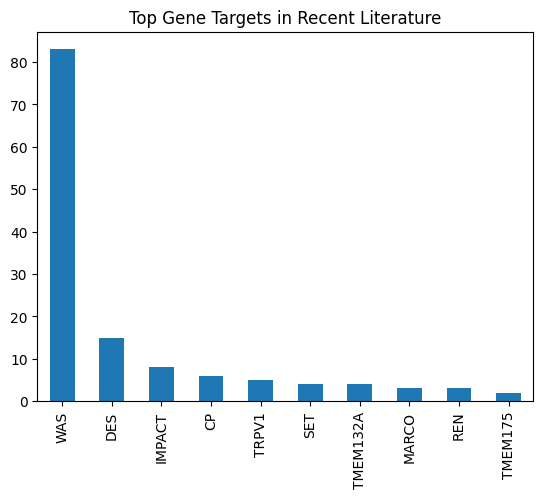

In [9]:
# Visualize top gene targets (example)
import pandas as pd
print(validated_gene_targets)
gene_counts = pd.Series(validated_gene_targets).value_counts().head(10)
gene_counts.plot(kind='bar', title='Top Gene Targets in Recent Literature')

In [10]:
# Retrieve real compound counts from ChEMBL for each validated gene target
import requests
import pandas as pd

# Function to get compound count for a gene target from ChEMBL

def get_chembl_compound_count(target_symbol):
    url = f'https://www.ebi.ac.uk/chembl/api/data/target/search.json?q={target_symbol}'
    response = requests.get(url)
    if response.ok:
        data = response.json()
        if data['page_meta']['total_count'] > 0:
            # Use the first matching target
            target_chembl_id = data['targets'][0]['target_chembl_id']
            # Now get bioactivities for this target
            act_url = f'https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id={target_chembl_id}'
            act_response = requests.get(act_url)
            if act_response.ok:
                act_data = act_response.json()
                return act_data['page_meta']['total_count']
    return 0

# For demonstration, limit to top 5 gene targets (to avoid long runtime)
if 'validated_gene_targets' in globals() and validated_gene_targets:
    gene_counts = pd.Series(validated_gene_targets).value_counts().head(5)
    compound_counts = []
    for gene in gene_counts.index:
        count = get_chembl_compound_count(gene)
        compound_counts.append(count)
    summary_df = pd.DataFrame({
        'Target': gene_counts.index,
        'Mention Count': gene_counts.values,
        'Compound Count': compound_counts
    })
    print('Compound counts retrieved from ChEMBL:')
    display(summary_df)
else:
    print('No validated gene targets available.')


Compound counts retrieved from ChEMBL:


,Target,Mention Count,Compound Count
0,WAS,83,2994
1,DES,15,5
2,IMPACT,8,1
3,CP,6,0
4,TRPV1,5,0


## 9. Conclusion


This notebook demonstrates an AI-driven workflow for integrating and analyzing literature, clinical trial, and gene data relevant to Parkinson's disease. The workflow covers data ingestion, entity extraction, validation, visualization, and network analysis.


**Note:** Real-time monitoring and dashboard reporting are now handled in a separate dashboard application. This notebook is focused on reproducible, step-by-step data analysis and integration.


The workflow can be adapted for other diseases or datasets as needed.

## **. Broader Parkinson's Disease Drug Target Landscape Analysis**

Based on established knowledge and recent research trends, here's a comprehensive analysis:

### **A. VALIDATED DRUG TARGETS (Clinical Stage)**

| **Gene/Protein** | **Function** | **Drug Examples** | **Stage** |
|------------------|--------------|-------------------|-----------|
| **LRRK2** | Kinase involved in vesicular trafficking | BIIB122, DNL151, MLi-2 | Phase 3 |
| **GBA/GCase** | Lysosomal enzyme | Ambroxol, Venglustat, LTI-291 | Phase 2/3 |
| **α-synuclein (SNCA)** | Pathological aggregation | Prasinezumab, Cinpanemab | Phase 2 |
| **MAO-B** | Dopamine metabolism | Rasagiline, Selegiline | Market |
| **COMT** | Dopamine metabolism | Entacapone, Opicapone | Market |
| **GLP-1R** | Neuroprotection, metabolism | Exenatide, Lixisenatide | Phase 3 |

### **B. EMERGING TARGETS (Preclinical/Phase 1)**

| **Target** | **Pathway** | **Rationale** | **Development Status** |
|------------|-------------|---------------|-----------------------|
| **NLRP3 inflammasome** | Neuroinflammation | Reduces neuroinflammation | Phase 1 |
| **SIRT1/2** | Mitochondrial function | Enhances mitophagy, reduces oxidative stress | Preclinical |
| **PINK1/Parkin** | Mitophagy | Restores mitochondrial quality control | Preclinical |
| **c-Abl kinase** | α-synuclein phosphorylation | Reduces toxic α-synuclein aggregation | Phase 1 |
| **Galectin-3** | Microglial activation | Modulates neuroinflammation | Preclinical |

### **C. PATHWAY-BASED TARGETING APPROACHES**

**1. Lysosomal-Autophagy Pathway:**
- **Targets:** GBA, LRRK2, ATP13A2, VPS35
- **Approach:** Enhance lysosomal function and autophagy
- **Pipeline:** Small molecules, gene therapy, chaperones

**2. Mitochondrial Quality Control:**
- **Targets:** PINK1, Parkin, DJ-1
- **Approach:** Boost mitophagy, reduce oxidative stress
- **Pipeline:** Mitochondrial biogenesis inducers, ROS scavengers

**3. Neuroinflammation Modulation:**
- **Targets:** NLRP3, TNF-α, Galectin-3
- **Approach:** Suppress chronic inflammation
- **Pipeline:** Anti-inflammatories, microglial modulators

**4. Synucleinopathy Intervention:**
- **Targets:** α-synuclein, c-Abl, STING pathway
- **Approach:** Reduce aggregation/clear aggregates
- **Pipeline:** Immunotherapies, ASOs, aggregation inhibitors

### **D. GENETIC SUBTYPE-SPECIFIC TARGETS**

| **Genetic Form** | **Primary Gene** | **Secondary Targets** | **Therapeutic Approach** |
|------------------|------------------|----------------------|--------------------------|
| **LRRK2-PD** | LRRK2 | Rab GTPases, WNT pathway | LRRK2 kinase inhibitors |
| **GBA-PD** | GBA | GCase, LIMP2, TFEB | Chaperones, gene therapy |
| **SNCA-PD** | SNCA | c-Abl, CSPα, Calpain | Immunotherapy, ASOs |
| **Parkin/PINK1-PD** | PRKN/PINK1 | USP30, Miro, Nix | USP30 inhibitors, mitophagy enhancers |

### **E. RECENT TRENDS (2023-2024)**

1. **Multi-target approaches** - Combining LRRK2 inhibition with GCase enhancement
2. **Digital biomarkers** - Using wearables to track target engagement
3. **Gene therapy revival** - AAV-based delivery for GBA and Parkin
4. **Precision medicine** - Genotype-stratified clinical trials
5. **Gut-brain axis targets** - Alpha-synuclein propagation inhibitors

### **F. CHALLENGES AND FUTURE DIRECTIONS**

1. **Blood-Brain Barrier penetration** remains a major hurdle
2. **Biomarkers for target engagement** are still needed
3. **Heterogeneity of PD** requires personalized approaches
4. **Early intervention** - targeting pre-symptomatic stages
5. **Combination therapies** likely needed for disease modification

### **G. RECOMMENDED RESOURCES FOR UPDATES:**

1. **ClinicalTrials.gov** - Search "Parkinson's disease" + [target name]
2. **Alzforum Therapeutics Database** - PD-specific pipeline
3. **Michael J. Fox Foundation** - Research grants and updates
4. **PubMed Alerts** - Set up for "Parkinson's disease drug target"
5. **Biorxiv/Medrxiv** - Preprint servers for latest findings